In [1]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import astropy.units as u
from os import path

import astropy.coordinates as coord
import astropy.units as u

In [2]:
prefix = '1to13'
path = '/astro/store/gradscratch/tmp/scw7/tessData/lightcurves/sec1to13/'
log_path = path + 'log/'

In [3]:
df = pd.read_csv(prefix + '_filt_flare_out.csv')
df_param = pd.read_csv(prefix + '_filt_param_out.csv')
len(df)

7495

In [33]:
# Match flare detections to gaia
tic_gaia_table = pd.read_csv('ticGAIA1to13.csv')
df_g = pd.merge(tic_gaia_table, df, on='TIC', how='inner')
df_g = df_g.dropna(subset=['lum'])
ed = (df_g['ed'].values*u.day).to(u.s)
ed_err = (df_g['ed_err'].values*u.day).to(u.s)
energy = (ed*df_g['lum']*u.erg/u.s).value
energy_err = (ed_err*df_g['lum']*u.erg/u.s).value
df_g['energy'] = energy
df_g['energy_err'] = energy_err
print(len(df), len(df_g), len(tic_gaia_table))

7495 5747 118887


In [5]:
tic_gaia_table.columns

Index(['Unnamed: 0', 'TIC', 'r_est', 'lum', 'G_BPbrmag', 'G_RPmag', 'G_mag',
       'source_id', 'ra', 'dec'],
      dtype='object')

In [35]:
c_fl = coord.SkyCoord(ra=df_g['ra'].values*u.deg, dec=df_g['dec'].values*u.deg, \
                      distance=df_g['r_est'].values*u.pc)
c_all = coord.SkyCoord(ra=tic_gaia_table['ra'].values*u.deg, dec=tic_gaia_table['dec'].values*u.deg, \
                      distance=tic_gaia_table['r_est'].values*u.pc)

In [36]:
# Only care about z, distance from galactic center doesnt matter
galcen = c_fl.transform_to(coord.Galactocentric(z_sun=0*u.pc, galcen_distance=8.1*u.kpc))
df_g['gal_z'] = np.fabs(galcen.z)
galcen = c_all.transform_to(coord.Galactocentric(z_sun=0*u.pc, galcen_distance=8.1*u.kpc))
tic_gaia_table['gal_z'] = np.fabs(galcen.z)

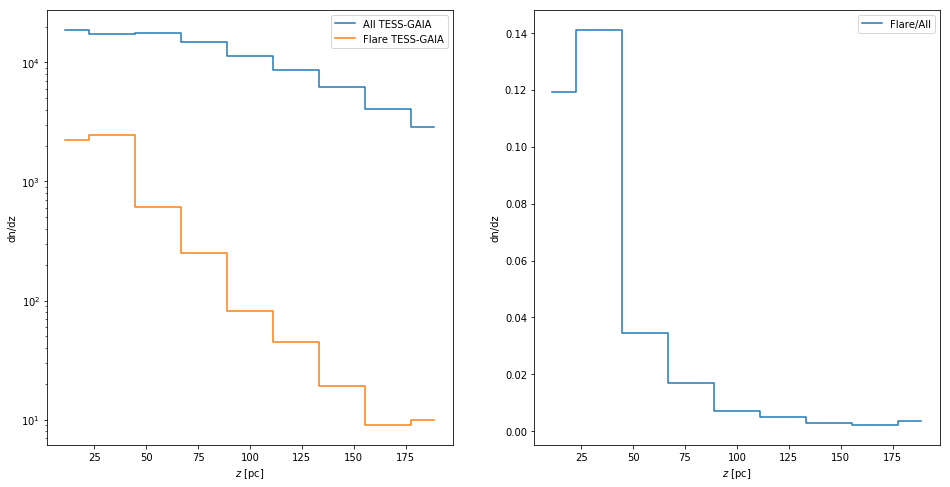

In [53]:
fig, axes = plt.subplots(figsize=(16,8), nrows=1, ncols=2)

zmin, zmax, nbins = 0, 200, 10

hist_all, bins_all = np.histogram(tic_gaia_table['gal_z'], bins=np.linspace(zmin, zmax, nbins))
bins_all = 0.5*(bins_all[1:] + bins_all[:-1])
axes[0].plot(bins_all, hist_all, linestyle='steps-mid', label='All TESS-GAIA')

hist_fl, bins_fl = np.histogram(df_g['gal_z'], bins=np.linspace(zmin, zmax, nbins))
bins_fl = 0.5*(bins_fl[1:] + bins_fl[:-1])
axes[0].plot(bins_fl, hist_fl, linestyle='steps-mid', label='Flare TESS-GAIA')

axes[0].set_yscale('log')
axes[0].set_xlabel('$z$ [{0:latex_inline}]'.format(galcen.z.unit))
axes[0].set_ylabel('dn/dz')
axes[0].legend()

axes[1].plot(bins_all, hist_fl/hist_all, linestyle='steps-mid', label='Flare/All')
axes[1].set_xlabel('$z$ [{0:latex_inline}]'.format(galcen.z.unit))
axes[1].set_ylabel('dn/dz')
axes[1].legend()